In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np


In [2]:
from google.colab import files

# This will prompt you to upload the zip file from your local machine
uploaded =files.upload()

Saving Dataset Brain Tumor.zip to Dataset Brain Tumor.zip


In [3]:
import zipfile
import os

# Specify the name of the uploaded zip file
zip_file_name = 'Dataset Brain Tumor.zip'  # Change this if your zip file name is different

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('Dataset Brain Tumor')

# Verify the contents of the unzipped directory
os.listdir('Dataset Brain Tumor')

['Dataset Brain Tumor']

In [4]:
# Set paths
train_dir = '/content/Dataset Brain Tumor/Dataset Brain Tumor/Training Dataset'
test_dir = '/content/Dataset Brain Tumor/Dataset Brain Tumor/Testing Dataset'

# Define image size and batch size
image_size = (240, 240)
batch_size = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Testing data generator without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 5708 images belonging to 4 classes.
Found 1273 images belonging to 4 classes.


In [12]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_cnn_model_with_relu_l1(input_shape):
    model = models.Sequential()

    # Convolutional Layer 1 with L1 Regularization
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_regularizer=regularizers.l1(0.001), input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2 with L1 Regularization
    model.add(layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_regularizer=regularizers.l1(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3 with L1 Regularization
    model.add(layers.Conv2D(128, (3, 3), activation='relu',
                            kernel_regularizer=regularizers.l1(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Fully Connected Layer with ReLU Activation and L1 Regularization
    model.add(layers.Dense(128, activation='relu',
                           kernel_regularizer=regularizers.l1(0.001)))

    # Output Layer with Softmax Activation
    model.add(layers.Dense(4, activation='softmax'))

    return model

# Input shape
input_shape = (240, 240, 3)  # Assuming RGB images

# Create the model
model_relu_l1 = create_cnn_model_with_relu_l1(input_shape)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_relu_l1.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model summary
model_relu_l1.summary()

# Fit the model (make sure train_generator and test_generator are defined)
history = model_relu_l1.fit(
    train_generator,
    epochs=30,  # Adjust based on your needs
    validation_data=test_generator
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 238, 238, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 117, 117, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 433ms/step - accuracy: 0.3380 - loss: 11.1470 - val_accuracy: 0.5805 - val_loss: 3.1180
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 417ms/step - accuracy: 0.5342 - loss: 3.0583 - val_accuracy: 0.5884 - val_loss: 2.9048
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - accuracy: 0.5803 - loss: 2.8391 - val_accuracy: 0.6017 - val_loss: 2.8168
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 421ms/step - accuracy: 0.5744 - loss: 2.8005 - val_accuracy: 0.5420 - val_loss: 2.7999
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 417ms/step - accuracy: 0.5893 - loss: 2.7331 - val_accuracy: 0.5947 - val_loss: 2.7671
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 416ms/step - accuracy: 0.5872 - loss: 2.7160 - val_accuracy: 0.6222 - val_loss: 2.7733
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 417ms/step - accuracy: 0.5962 - loss: 2.6846 - val_accuracy: 0.5640 - val_loss: 2.7562
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 415ms/step - accuracy: 0.5945 - loss: 

In [13]:
# Evaluate on test data
test_loss, test_acc = model_relu_l1.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Predict the probabilities for test data
y_pred = model_relu_l1.predict(test_generator)
y_true = test_generator.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# AUC Score
auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
print(f'AUC Score: {auc:.4f}')


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5052 - loss: 2.8915
Test Accuracy: 0.5994
Test Loss: 2.6940
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.68      0.54      0.60       262
  meningioma       0.55      0.18      0.27       306
     notumor       0.65      0.80      0.72       405
   pituitary       0.52      0.80      0.63       300

    accuracy                           0.60      1273
   macro avg       0.60      0.58      0.56      1273
weighted avg       0.60      0.60      0.57      1273

AUC Score: 0.8169


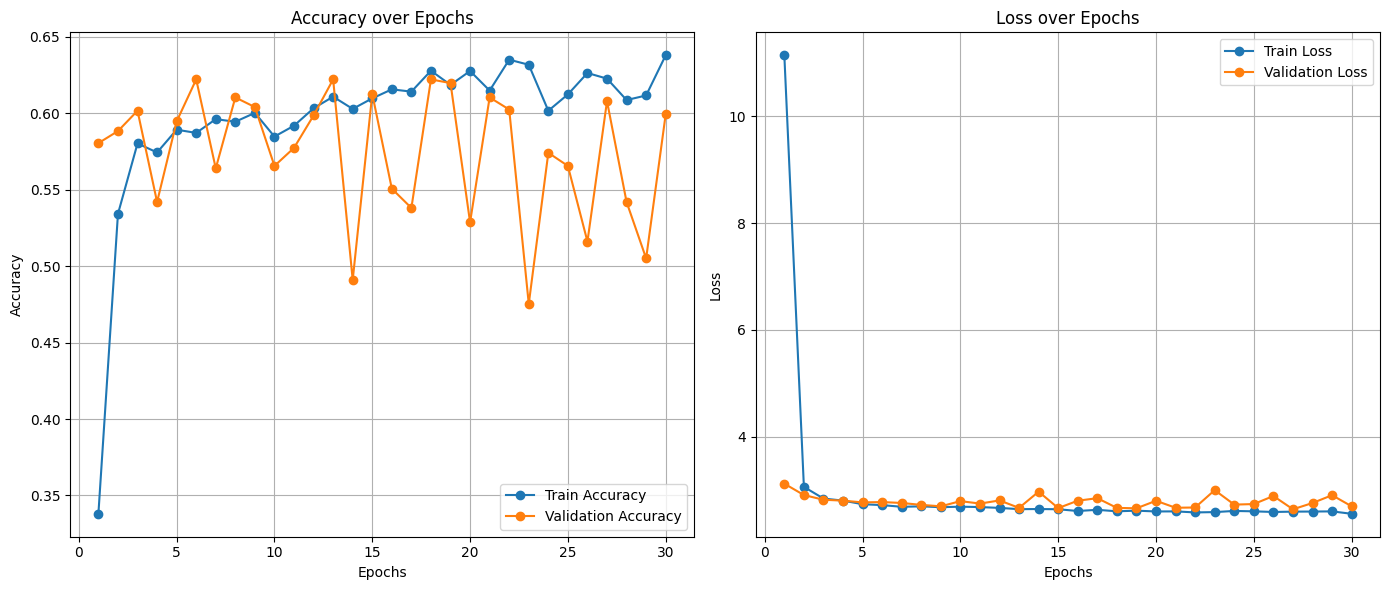

In [14]:
import matplotlib.pyplot as plt

# Replace these lists with your actual values
epochs = range(1, 31)
train_accuracy = [0.3380, 0.5342, 0.5803, 0.5744, 0.5893, 0.5872, 0.5962, 0.5945, 0.6003, 0.5848,
                   0.5919, 0.6033, 0.6109, 0.6029, 0.6098, 0.6157, 0.6142, 0.6279, 0.6186, 0.6277,
                   0.6149, 0.6351, 0.6318, 0.6017, 0.6124, 0.6264, 0.6227, 0.6087, 0.6117, 0.6380]
val_accuracy = [0.5805, 0.5884, 0.6017, 0.5420, 0.5947, 0.6222, 0.5640, 0.6104, 0.6041, 0.5656,
                 0.5774, 0.5986, 0.6222, 0.4910, 0.6127, 0.5507, 0.5381, 0.6222, 0.6198, 0.5287,
                 0.6104, 0.6025, 0.4753, 0.5742, 0.5656, 0.5161, 0.6080, 0.5420, 0.5051, 0.5994]
train_loss = [11.1470, 3.0583, 2.8391, 2.8005, 2.7331, 2.7160, 2.6846, 2.6930, 2.6769, 2.6868,
               2.6794, 2.6639, 2.6402, 2.6427, 2.6386, 2.6058, 2.6281, 2.6000, 2.6122, 2.5971,
               2.5986, 2.5790, 2.5852, 2.6068, 2.5996, 2.5875, 2.5938, 2.5957, 2.5986, 2.5534]
val_loss = [3.1180, 2.9048, 2.8168, 2.7999, 2.7671, 2.7733, 2.7562, 2.7203, 2.6934, 2.7907,
             2.7450, 2.8038, 2.6644, 2.9681, 2.6606, 2.7986, 2.8459, 2.6642, 2.6563, 2.7974,
             2.6667, 2.6715, 2.9965, 2.7256, 2.7358, 2.8868, 2.6381, 2.7554, 2.9019, 2.6940]

plt.figure(figsize=(14, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
